# The Simpsons

In [1]:
import pandas as pd

## Data wrangling

### CSV files

In [2]:
locations = pd.read_csv('simpsons_locations.csv')
characters = pd.read_csv('simpsons_characters.csv')
episodes = pd.read_csv('simpsons_episodes.csv')

To perform joins and merges between dataframes, I think it's handy to set the DataFrames' indexes to be equal to the IDs.

In [3]:
locations.index = locations['id']
characters.index = characters['id']
episodes.index = episodes['id']

### Custom parsing

The simpsons_script_lines.csv file uses double quotes in a non consistent way. We need to parse it manually. For example:

<pre>17667
59
87
Singers: (SINGING) "IT'S THE FIRST ANNUAL MONTGOMERY BURNS/ AWARD FOR --
442000
true
276
636
Singers
Springfield Civic Center
"IT'S THE FIRST ANNUAL MONTGOMERY BURNS/ AWARD FOR --
its the first annual montgomery burns award for --
9
</pre>

In [4]:
import re
from collections import defaultdict

In [5]:
regex_str = r'''^
                (\d+),          # id - mandatory
                (\d+),          # episode_id - mandatory
                (\d+),          # number - mandatory
                (.+),           # raw_text - mandatory
                (\d+),          # timestamp - mandatory
                (true|false),   # speaking line - mandatory
                (\d*),          # character_id - optional
                (\d*),          # location_id - optional
                (.*),           # raw_character_text - optional
                (.*),           # raw_location_text - optional
                (.*),           # spoken_words - optional
                (.*),           # normalized_text - optional
                (\d*)           # word_count - optional
                $'''

regex = re.compile(regex_str, re.X)

In [6]:
def read_script_lines_csv():
    '''Custom function to parse CSV file containing script lines.
    
    Returns:
        pandas.DataFrame: parsed data
   
    '''
    data = defaultdict(list)

    with open('simpsons_script_lines.csv', 'r') as csv_file:
        column_names = None
        for n_line, line in enumerate(csv_file):
            line = line.strip()
            if len(line) == 0:
                continue
            if column_names is None:
                column_names = line.split(',')
                assert len(column_names) == regex.groups
            else:
                assert not column_names is None
                m = regex.match(line)
                if not m:
                    assert False, 'Line {} is not parsable'.format(n_line)
                for n_col, col in enumerate(column_names):
                    # RE match groups start from 1
                    data[col].append(m.group(n_col + 1))

    data = pd.DataFrame(data)
    data['id'] = data['id'].astype(int)
    data['episode_id'] = data['episode_id'].astype(int)
    data['number'] = data['number'].astype(int)
    return data

In [7]:
script_lines = read_script_lines_csv()

## Data analysis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white", color_codes=True)

Let's check the data size first and its basic consistency.

In [9]:
for name, df, attr in (('locations', locations, 'name'),
                       ('characters', characters, 'name'),
                       ('episodes', episodes, 'title')):
    
    print('Total number of {} = {} / {}'.format(name, df['id'].count(),
                                                len(df[attr].unique())))


Total number of locations = 4459 / 4459
Total number of characters = 6722 / 6722
Total number of episodes = 600 / 600


### Episodes per season

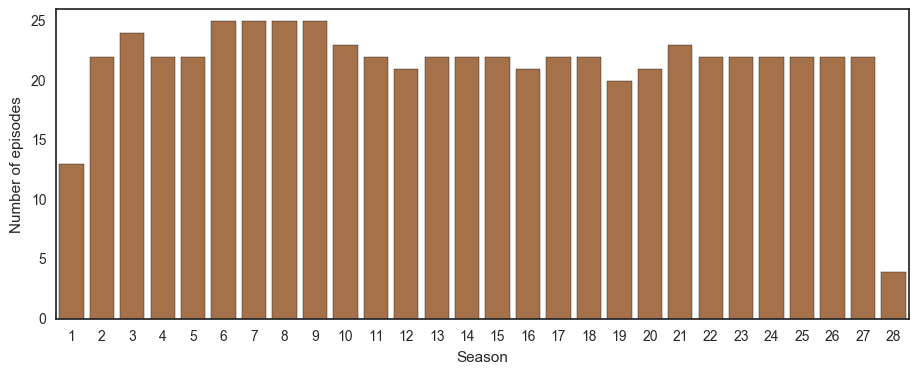

In [10]:
episodes_count = episodes.groupby('season')['number_in_season'].count()

f, ax = plt.subplots(figsize=(11, 4))
sns.barplot(episodes_count.index, episodes_count.values, color="chocolate", saturation=.5, ax=ax)
ax.set(xlabel='Season', ylabel='Number of episodes')
_ = ax.set_ylim([0, 26])

### US viewers

#### Average no. of viewers per season

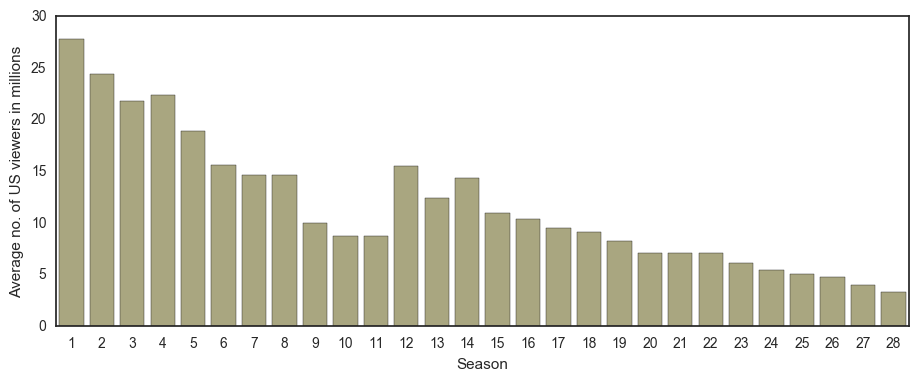

In [11]:
viewers_mean = episodes.groupby('season')['us_viewers_in_millions'].mean()

f, ax = plt.subplots(figsize=(11, 4))
sns.barplot(viewers_mean.index, viewers_mean.values, color="DarkKhaki", saturation=.5, ax=ax)
ax.set(xlabel='Season', ylabel='Average no. of US viewers in millions')
_ = ax.set_ylim([0, 30])

#### Top 10 episodes

In [12]:
episodes.sort_values(by='us_viewers_in_millions', ascending=False) \
    .iloc[:10][['title', 'season', 'number_in_season', 'us_viewers_in_millions']]

title  season  number_in_season  us_viewers_in_millions
id                                                                            
14          Bart Gets an "F"       2                 1                    33.6
9      Life on the Fast Lane       1                 9                    33.5
11       The Crepes of Wrath       1                11                    31.2
12        Krusty Gets Busted       1                12                    30.4
10         Homer's Night Out       1                10                    30.3
15       Simpson and Delilah       2                 2                    29.9
69         Lisa's First Word       4                10                    28.6
8          The Telltale Head       1                 8                    28.0
7   The Call of the Simpsons       1                 7                    27.6
3            Homer's Odyssey       1                 3                    27.5

Let's visualize the linear regression of no. of viewers and IMDB rating. It's seems very plausible that they are positively correlated:

#### Correlation no. of viewers / IMDB rating

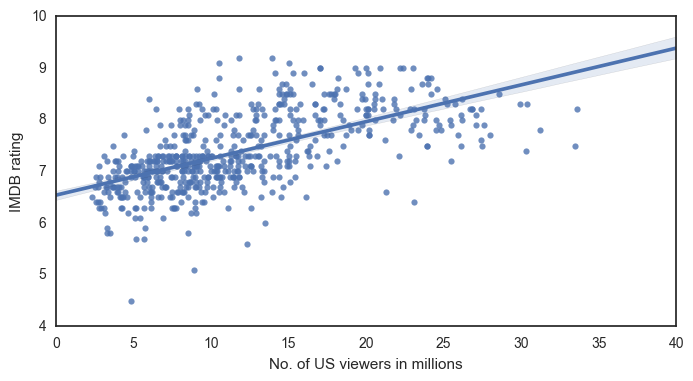

In [13]:
f, ax = plt.subplots(figsize=(8, 4))
sns.regplot(x="us_viewers_in_millions", y="imdb_rating", data=episodes, ax=ax)
_ = ax.set(xlabel='No. of US viewers in millions', ylabel='IMDB rating')

### Script lines

#### Most frequent characters

In [14]:
def get_characters_by_speak_freq(lines):
    '''Computes how often each character speaks inside the "script lines" file.
    
    Returns:
        pandas.DataFrame:
    
    '''
    d = lines \
        .groupby('character_id') \
        .size() \
        .sort_values(ascending=False)
    # Convert Series back to DataFrame and rename the column to "counts"    
    d = pd.DataFrame(d.rename('counts'))
    d.index = d.index.astype(int)
    d = d.join(characters)
    return d

In [15]:
speaking_lines = script_lines[
    (script_lines['character_id'] != '') & (script_lines['speaking_line'] == 'true')]
characters_by_speak_freq = get_characters_by_speak_freq(speaking_lines)
characters_by_speak_freq[['name', 'normalized_name', 'counts']].iloc[:25]
# TODO piechart

name          normalized_name  counts
character_id                                                          
2                       Homer Simpson            homer simpson   28177
1                       Marge Simpson            marge simpson   13297
8                        Bart Simpson             bart simpson   13204
9                        Lisa Simpson             lisa simpson   10898
15                C. Montgomery Burns       c montgomery burns    3121
17                        Moe Szyslak              moe szyslak    2810
3                     Seymour Skinner          seymour skinner    2390
11                       Ned Flanders             ned flanders    2058
31                     Grampa Simpson           grampa simpson    1875
25                Milhouse Van Houten      milhouse van houten    1798
71                       Chief Wiggum             chief wiggum    1796
139                  Krusty the Clown         krusty the clown    1720
101                      Nelson Muntz             nelson muntz    1145
165                     Lenny Leonard            lenny leonard    1144
208            Apu Nahasapeemapetilon   apu nahasapeemapetilon     988
14                    Waylon Smithers          waylon smithers     965
211                     Kent Brockman            kent brockman     905
170                      Carl Carlson             carl carlson     852
40            Edna Krabappel-Flanders  edna krabappel-flanders     761
332                Dr. Julius Hibbert        dr julius hibbert     673
22                      Selma Bouvier            selma bouvier     566
18                      Barney Gumble            barney gumble     559
140              Rev. Timothy Lovejoy      rev timothy lovejoy     554
153                      Sideshow Bob             sideshow bob     527
1078                    Gary Chalmers            gary chalmers     519

#### Homer's classifier

In this section I will create a classifier to recognize Homer Simpson. For this example, to limit the training time, I will use only episodes of the first 5 seasons.

In [16]:
homer_id = '2'
episodes_ids_to_filter = episodes[episodes['season'].isin(range(1, 6))]['id']
filtered_speaking_lines = speaking_lines[speaking_lines['episode_id'].isin(episodes_ids_to_filter)]
# Create labels as array of 0s and 1s
labels = (filtered_speaking_lines['character_id'] == homer_id) \
    .astype(int) \
    .as_matrix()
print('No. of speaking lines to classify = {}'.format(len(labels)))
print('No. of lines spoken by Homer = {}'.format(sum(labels)))


No. of speaking lines to classify = 25940
No. of lines spoken by Homer = 5868


Let's create the stemmer and the vectorizer.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem

english_stemmer = nltk.stem.SnowballStemmer('english')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [18]:
vectorizer = StemmedTfidfVectorizer(min_df=1, stop_words='english', analyzer='word', ngram_range=(1,1))

I extract the field "normalized_text", because it is already cleaned from comments and punctuation. Then I split the test and train sets:

In [19]:
word_data = filtered_speaking_lines['normalized_text'].as_matrix()

In [20]:
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(
    word_data, labels, test_size=0.1, random_state=42) # TODO remove random_state

In [21]:
print('Word data size = {}'.format(len(word_data)))
print('Training features size = {}'.format(len(features_train)))
print('Testing features size = {}'.format(len(features_test)))
print('Training labels size = {}'.format(len(labels_train)))
print('Testing labels size = {}'.format(len(labels_test)))

Word data size = 25940
Training features size = 23346
Testing features size = 2594
Training labels size = 23346
Testing labels size = 2594


I train the vectorizer and transform the text input.

In [22]:
# vectorizer.fit(word_data) # TODO ???
vectorizer.fit(features_train)
features_train = vectorizer.transform(features_train)
features_test = vectorizer.transform(features_test)

In [23]:
from sklearn.feature_selection import SelectPercentile, f_classif
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features_train, labels_train)
selected_features_train = selector.transform(features_train).toarray()
selected_features_test  = selector.transform(features_test).toarray()

In [24]:
print('Selected training data size = {}'.format(len(selected_features_train)))
print('Selected testing data size = {}'.format(len(selected_features_test)))
assert len(selected_features_test[0]) == len(selected_features_train[0])
print('Number of selected features = {}'.format(len(selected_features_train[0])))

Selected training data size = 23346
Selected testing data size = 2594
Number of selected features = 1120


In [25]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [26]:
from time import time
t0 = time()
clf = clf.fit(selected_features_train, labels_train)
print("Training time: ", round(time() - t0, 3), "s")

Training time:  105.294 s


In [27]:
t0 = time()
accuracy = clf.score(selected_features_test, labels_test)
print("Testing time: ", round(time() - t0, 3), "s")
print('Accuracy = {}'.format(accuracy))

Testing time:  0.038 s
Accuracy = 0.7490362374710872
